# Quantifying the Confidence of Anomaly Detectors in Their Example-Wise Predictions (ExCeeD)

In [93]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import seaborn as sns #if you get error, use the line !pip install seaborn

from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM

from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import binom
from ExCeeD import *

def ignore_warnings():
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    warnings.simplefilter(action='ignore', category=Warning)

ignore_warnings()
np.random.seed(331)

# Generating artificial examples

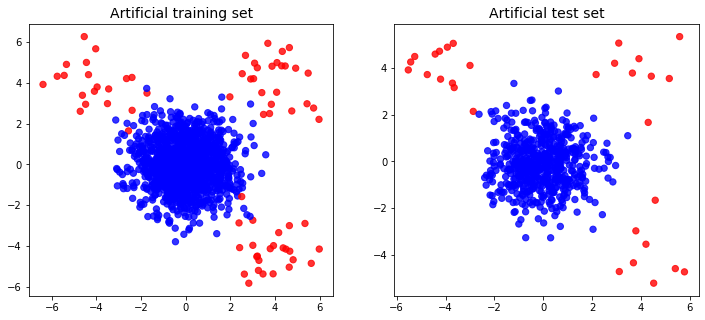

In [99]:
dataset_size = 2000
numerical_col = ['dim_1','dim_2']
class_prior = 0.95 #real class prior
contamination = 1-class_prior

#Training set
a1_ = np.random.randn(2, np.int(dataset_size*(1-class_prior)/3))
a2_ = np.random.randn(2, np.int(dataset_size*(1-class_prior)/3))
a3_ = np.random.randn(2, np.int(dataset_size*contamination) - 2*np.int(dataset_size*(1-class_prior)/3))
num_anom = a1_.shape[1] + a2_.shape[1]+ a3_.shape[1]

n1_ = np.random.randn(2, np.int(dataset_size-num_anom))*1.1
y = np.zeros(dataset_size, dtype=np.int)
y[:num_anom] = +1


a1_[0, :] += 4.0
a1_[1, :] -= 4.0
a2_[0, :] -= 4.0
a2_[1, :] += 4.0
a3_[0, :] += 4.0
a3_[1, :] += 4.0

data_set = np.concatenate((a1_, a2_, a3_, n1_), axis=1)

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=331)
for train_index, test_index in sss.split(data_set.T, y):
    X_train, X_test = data_set.T[train_index], data_set.T[test_index]
    y_train, y_test = y[train_index], y[test_index]

n = len(y_train)
m = len(y_test)
num_train_anom = np.count_nonzero(y_train)

#Plot training and test sets
fig = plt.figure(figsize=(12, 5), facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
colors = np.array(['b' if y_train[i] == 0 else 'r' for i in range(n)])# ['g', 'r'])
plt.scatter(X_train.T[0],X_train.T[1], 40, colors, alpha = 0.8)
plt.title("Artificial training set", fontsize=14)
plt.subplot(1, 2, 2)
colors = np.array(['b' if y_test[i] == 0 else 'r' for i in range(m)])# ['g', 'r'])
plt.scatter(X_test.T[0],X_test.T[1], 40, colors, alpha = 0.8)
plt.title("Artificial test set", fontsize=14)
plt.show()

# Example-Wise Confidence Estimation by ExCeeD

In [3]:
# Train the classifiers (KNNO, IForest and OCSVM)
knno = KNN(n_neighbors=np.int(n*contamination), contamination = contamination).fit(X_train)
train_scores_knno = knno.decision_function(X_train)
test_scores_knno = knno.decision_function(X_test)
prediction_knno = knno.predict(X_test)

iforest = IForest(contamination = contamination, random_state = 331).fit(X_train)
train_scores_iforest = iforest.decision_function(X_train)
test_scores_iforest = iforest.decision_function(X_test)
prediction_iforest = iforest.predict(X_test)

ocsvm = OCSVM(contamination = contamination).fit(X_train)
train_scores_ocsvm = ocsvm.decision_function(X_train)
test_scores_ocsvm = ocsvm.decision_function(X_test)
prediction_ocsvm = ocsvm.predict(X_test)


In [4]:
# Compute the pointwise confidence for each model and each example in the test set:

knno_confidence = ExCeeD(train_scores_knno, test_scores_knno, prediction_knno, contamination)

iforest_confidence = ExCeeD(train_scores_iforest, test_scores_iforest, prediction_iforest, contamination)

ocsvm_confidence = ExCeeD(train_scores_ocsvm, test_scores_ocsvm, prediction_ocsvm, contamination)

### Heatmap using the artificial test set for ExCeeD confidence

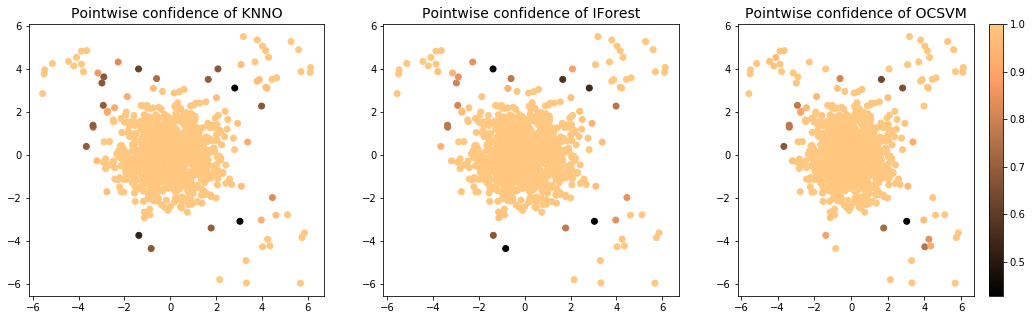

In [5]:
plt.figure(figsize=(18, 5))
# plot the contour
plt.subplot(1,3,1)
plt.title("Pointwise confidence of KNNO", fontsize= 14)
plt.scatter(X_test.T[0], X_test.T[1], c=knno_confidence, cmap=plt.cm.copper)
plt.subplot(1,3,2)
plt.title("Pointwise confidence of IForest", fontsize= 14)
plt.scatter(X_test.T[0], X_test.T[1], c=iforest_confidence, cmap=plt.cm.copper)
plt.subplot(1,3,3)
plt.title("Pointwise confidence of OCSVM", fontsize= 14)
plt.scatter(X_test.T[0], X_test.T[1], c=ocsvm_confidence, cmap=plt.cm.copper)
plt.colorbar()

plt.show()

### Heatmap using space grid as test for ExCeeD confidence

In [96]:
def plot_2D_classifier(X, clf, contamination, steps=150, margin_size=0.05, figure_size=(8, 5)):
    #Here we make a grid in the sample space (from min to max) and we consider each example of
    #the grid as a test example. As a result, a heatmap of potential confidence values is shown.
    
    # ranges
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_range = abs(x_max - x_min)
    y_range = abs(y_max - y_min)

    xmin, xmax = x_min - margin_size * x_range, x_max + margin_size * x_range
    ymin, ymax = y_min - margin_size * y_range, y_max + margin_size * y_range
    
    # make the meshgrid based on the data 
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, int(steps)),
        np.linspace(ymin, ymax, int(steps)))
    X_mesh = np.c_[xx.ravel(), yy.ravel()]

    # fit and predict the classifier
    test_scores = clf.decision_function(X_mesh)
    train_scores = clf.decision_function(X)
    prediction = clf.predict(X_mesh)
    exceed_confidence = ExCeeD(train_scores, test_scores, prediction, contamination)

    Z = exceed_confidence.reshape(xx.shape)
    plt.figure(figsize=figure_size)
    plt.title("Heat map about Example-Wise Confidence by ExCeeD", fontsize= 14)
    
    # plot the contour
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm,norm=matplotlib.colors.Normalize(vmin=0, vmax=1),
                 alpha=0.8)
    ax, _ = matplotlib.colorbar.make_axes(plt.gca(), shrink=1.0)
    cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=plt.cm.coolwarm,
                           norm=matplotlib.colors.Normalize(vmin=0, vmax=1),
                                           ticks = np.arange(0,105,5)/100)
    cbar.set_clim(0.0, 1.0)
    
    #add the blue points
    plt.subplot(1,1,1)
    plt.scatter(X[:, 0], X[:, 1], s=35, edgecolors='k')
    
    sns.despine(right = True) #clean up
    plt.show()

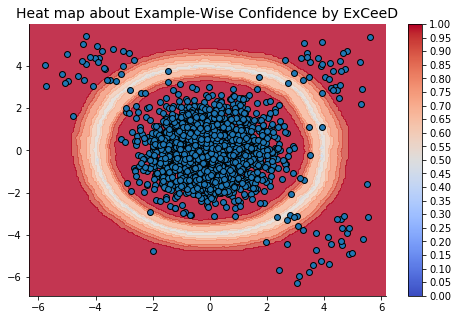

In [97]:
clf1 = KNN(n_neighbors=np.int(len(data_set.T)*contamination),contamination = contamination).fit(data_set.T)
clf2 = IForest(contamination = contamination, random_state = 331).fit(data_set.T)
clf3 = OCSVM(contamination = contamination).fit(data_set.T)

plot_2D_classifier(data_set.T, clf1, contamination) #choose clf1, clf2, clf3 or train another model

# Evaluating ExCeeD & state-of-the-art methods on a Benchmark Dataset

In [55]:
from evaluate_ExCeeD import *
from scipy.io import arff

data = arff.loadarff('/Benchmark_Datasets/Cardiotocography_withoutdupl_norm_05_v02.arff')
df = pd.DataFrame(data[0])
df['outlier'] = [string.decode("utf-8") for string in df['outlier'].values]
y_set = np.asarray([1 if string == 'yes' else 0 for string in df['outlier'].values])
X_set = df[df.columns[:21]].values #insert the effective features (no response label y)

model = 'KNN' #otherwise 'IForest', 'LOF', 'OCSVM'

L2_error = compute_confidence_error(model, X_set, y_set) #dictionary with the L2 errors

print('L2 error between confidence methods and empirical frequencies:')
for key in L2_error.keys():
    print(key+':',sum(L2_error[key])/2)

L2 error between confidence methods and empirical frequencies:
exceed: 0.0007871036495909716
exceed_sp: 0.44044675115341375
squash: 0.44044675115341375
linear: 0.4286615766893181
unify: 0.06789497186877089
logcal: 0.23398901742264508
isocal: 0.232117407922291
betacal: 0.23823242819725426
baseline: 0.013530438022100702
